<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Causal Inference In Statistics - A Primer</h1>
        <h1>3.6 Inverse Probability Weighing</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
    <div style="float: right; margin-right:10px;"> <p><a href="https://amzn.to/3gsFlkO" target=_blank><img src='data/causality.jpeg' width='100px'>
        <!--Amazon Affiliate Link--></a></p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 

from CausalModel import CausalModel

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: 6ba5a323994ecc2dbeee8be27219dbf5207f8dfb

numpy     : 1.19.2
matplotlib: 3.3.2
watermark : 2.1.0
pandas    : 1.1.3



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

We load the DAG from Fig 1.10 for ease of reference

In [4]:
G = CausalModel('dags/Primer.Fig.1.10.dot')

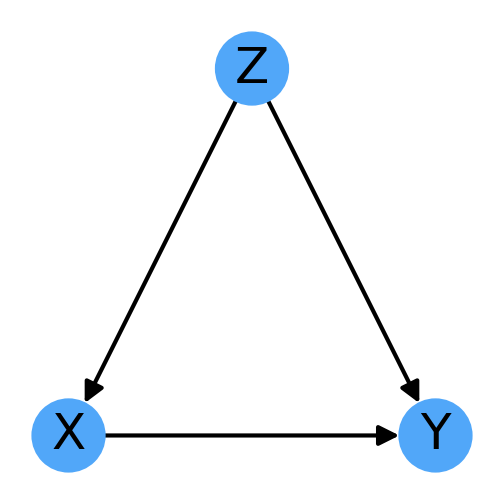

In [5]:
fig, ax = plt.subplots(1, figsize=(2.2,2.2))
G.plot(ax=ax)

In our example, the data for the joint probability $P\left(X, Y, Z\right)$ is:

In [6]:
PXYZ = pd.DataFrame({
    'X':    ['Yes',  'Yes',    'Yes',  'Yes',    'No',   'No',     'No',   'No'],
    'Y':    ['Yes',  'Yes',    'No',   'No',     'Yes',  'Yes',    'No',   'No'],
    'Z':    ['Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female'],
    'Prob': [0.116,   0.274,    0.009,   0.101,    0.334,  0.079,    0.051,  0.036]
})

In [7]:
PXYZ

,X,Y,Z,Prob
0,Yes,Yes,Male,0.116
1,Yes,Yes,Female,0.274
2,Yes,No,Male,0.009
3,Yes,No,Female,0.101
4,No,Yes,Male,0.334
5,No,Yes,Female,0.079
6,No,No,Male,0.051
7,No,No,Female,0.036


We check that it all sums up to one

In [8]:
PXYZ['Prob'].sum()

1.0

The conditional probability $P\left(Y, Z | X\right)$ for X=Yes:

In [9]:
PYZ_X = PXYZ[PXYZ['X'] == 'Yes'].copy()
PYZ_X['Prob'] /= PYZ_X['Prob'].sum()

In [10]:
PYZ_X.round(3)

,X,Y,Z,Prob
0,Yes,Yes,Male,0.232
1,Yes,Yes,Female,0.548
2,Yes,No,Male,0.018
3,Yes,No,Female,0.202


These numbers still differ slightly from the corrected in the [online Errata](http://bayes.cs.ucla.edu/PRIMER/pearl-etal-2016-primer-errata-pages-july2020.pdf)

Here we note that these values are just the corresponding values of $P\left(X, Y, Z\right)$ divided by $P\left(X=\mathrm{Yes}\right)$

In [11]:
PX = PXYZ[['X', 'Prob']].groupby('X', as_index=False).sum()

In [12]:
PX

,X,Prob
0,No,0.5
1,Yes,0.5


Please note that the calculations in earlier editions of the book are wrong. For instance, in Page 74 we have:

In [13]:
0.116+0.274+0.01+0.101

0.501

since they didn't correct the 0.01 to 0.009.

The gender distribution is:

In [14]:
PZ = PXYZ[['Z', 'Prob']].groupby('Z').sum()

In [15]:
PZ

,Prob
Z,
Female,0.49
Male,0.51


And the conditional probability $P\left(\mathrm{Drug}|\mathrm{Gender}\right)$ is:

In [16]:
PX_Z = PXYZ[['X', 'Z', 'Prob']].groupby(['X', 'Z'], as_index=False).sum()
PX_Z['Prob'] = PX_Z.apply(lambda x: x['Prob']/PZ.loc[x.Z], axis=1) #Normalization

In [17]:
PX_Z.set_index(['X', 'Z'], inplace=True)

In [18]:
PX_Z

Prob
X   Z               
No  Female  0.234694
    Male    0.754902
Yes Female  0.765306
    Male    0.245098

The lack of correction for 0.009 subsists even in $P\left(Y|Male\right)$ which is why we obtain 0.245 instead of 0.247

The results of the intervention, as calculated the inverse probability weighing are then:

In [19]:
PYdoXZ = PXYZ.copy()

In [20]:
PYdoXZ['Prob'] = PYdoXZ.apply(lambda x: x.Prob/PX_Z.loc[x.X, x.Z], axis=1)

In [21]:
PYdoXZ.round(3)

,X,Y,Z,Prob
0,Yes,Yes,Male,0.473
1,Yes,Yes,Female,0.358
2,Yes,No,Male,0.037
3,Yes,No,Female,0.132
4,No,Yes,Male,0.442
5,No,Yes,Female,0.337
6,No,No,Male,0.068
7,No,No,Female,0.153


The small differences we observe with respect to the corrected version in the [online Errata](http://bayes.cs.ucla.edu/PRIMER/pearl-etal-2016-primer-errata-pages-july2020.pdf) are due to the lack of correction from 0.01 to 0.009 as noted above.

And finally, the intervention values are:

In [22]:
PYdoX = PYdoXZ[['X', 'Y', 'Prob']].groupby(['Y', 'X'], as_index=False).sum()

In [23]:
PYdoX.round(3)

,Y,X,Prob
0,No,No,0.221
1,No,Yes,0.169
2,Yes,No,0.779
3,Yes,Yes,0.831


<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>